# 2023.06.30 FishEye Lens Calibration 시도

https://medium.com/@kennethjiang/calibrate-fisheye-lens-using-opencv-333b05afa0b0


- 다양한 각도로 체크보드 (6x8 코너) 촬영, 코너가 찾아지는 이미지 선정하여 data2폴더에 저장
- 미디엄 글 part1 따라서 calibration.py 진행 --> 찾아진 계수를 이용하여 undistorted이미지 생성, data2/undistorted폴더에 저장
- 미디엄 글 part2 따라서 원본이 소실되는 정도를 조정하는 시도. -->결과 data2/undistorted_broader폴더에 저장


# 1. Calibration.py 부분

- 사용한 체커보드 dim으로 수정 CHECKERBOARD = (6,8)

- 이슈1 : line#37 에서cv2.fisheye.calibrate() 에 calibration_flags그대로 사용시 에러발생, cv2.fisheye.CALIB_CHECK_COND (=4)만큼 빼주면 돌긴함.
- 이슈2 : 계산하려는 파라미터가 카메라매트릭스(K)와 왜곡계수(D)인데... D가 모두 0으로 나오는게 문제. 
- 카메라 매트릭스 값은 잘 찾아지는 듯 함. (이미지크기= 1920x1080 인데 중심점 (cx, cy)= (959.5, 539.5)인것으로 보아...

$camera\; matrix (K) = \begin{bmatrix}
f_x & 0 & c_x\\
0 & f_y & c_y\\
0 & 0 & 1
\end{bmatrix}
$</br>


In [46]:
import cv2
assert cv2.__version__[0] == '3', 'The fisheye module requires opencv version >= 3.0.0'
import numpy as np
import os
import glob
CHECKERBOARD = (6,8)
criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-4)
criteria = (cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_NORMALIZE_IMAGE,30,1e-4)
#flags =                              cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC+cv2.fisheye.CALIB_FIX_SKEW
#flags = cv2.fisheye.CALIB_CHECK_COND+cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC++cv2.fisheye.CALIB_FIX_SKEW
flags = cv2.fisheye.CALIB_CHECK_COND
flags = cv2.fisheye.CALIB_FIX_INTRINSIC

#objp = np.zeros((1, CHECKERBOARD[0]*CHECKERBOARD[1], 3), np.float32)
#objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)

objp = np.zeros([CHECKERBOARD[0]*CHECKERBOARD[1], 3],np.float32)
idx=0
for i in range(CHECKERBOARD[0]):S
    for j in range(CHECKERBOARD[1]):
        objp[idx] = np.array([j,i,0])
        idx+=1
_img_shape = None
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('./data2/*.jpg')
#images = glob.glob('/mnt/d/20230726_SVM/20230726_iToF_calibration_svm/data/20230726_id2/result_imgs_IR/*.jpg')
images.sort()
#print(images)
images = images[:10]
print(images)
for fname in images:
    img = cv2.imread(fname)
    #if _img_shape == None:
    #    _img_shape = img.shape[:2]
    #else:
    #    assert _img_shape == img.shape[:2], "All images must share the same size."
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, None)#cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_FAST_CHECK+cv2.CALIB_CB_NORMALIZE_IMAGE)
    #ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_FAST_CHECK+cv2.CALIB_CB_NORMALIZE_IMAGE)
    
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        cv2.cornerSubPix(gray,corners,(3,3),(-1,-1),(criteria))
        imgpoints.append(corners)
        #imgpoints.append(corners.reshape(1,-1,2))
        print(objp.shape,corners.shape)
N_OK = len(objpoints)
#K = np.eye(3, dtype=np.float32)
K=np.array([
    [376.33, 0.0, 315.5], [0.0, 377.665, 243.0], [0.0, 0.0, 1.0]])
D = np.zeros((4, 1), dtype=np.float32)
rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
#objpoints = np.array(objpoints)#.reshape(-1,1,3)
#objpoints = np.expand_dims(np.asarray(objpoints),-2)
#imgpoints = np.array(imgpoints)#.reshape(-1,1,3)
#imgpoints = np.swapaxes(imgpoints,1,2)
objpoints = np.expand_dims(objpoints,-2)#.reshape(-1,1,3)#.reshape(-1,1,3)
imgpoints = np.array(imgpoints)#.reshape(-1,1,2)
print(objpoints.shape)
print(imgpoints.shape)

#print(objpoints.reshape(-1,1,3).shape,np.array(imgpoints).reshape(-1,1,2).shape)
rms, K, D, rvecs, tvecs =    cv2.fisheye.calibrate(
        objpoints,
        imgpoints,
        gray.shape[::-1],
        K,        D,
        rvecs,
        tvecs,
        flags=cv2.fisheye.CALIB_FIX_SKEW )
print("Found " + str(N_OK) + " valid images for calibration")
#print("DIM=" + str(_img_shape[::-1]))
print("K=np.array(" + str(K.tolist()) + ")")
print("D=np.array(" + str(D.tolist()) + ")")

['./data2/08.jpg', './data2/09.jpg']
(48, 3) (48, 1, 2)
(48, 3) (48, 1, 2)
(2, 48, 1, 3)
(2, 48, 1, 2)
Found 2 valid images for calibration
K=np.array([[978.1087567546703, 0.0, 972.1357825844062], [0.0, -848.0931177694883, 1450.6327157062528], [0.0, 0.0, 1.0]])
D=np.array([[0.7164201140403748], [-10.337958335876465], [31.713518142700195], [-26.735157012939453]])


# 2. undistorted 이미지 생성 부분

- 코드는 잘 돌긴하나 모두 0으로 채워진 왜곡계수(D)때문에 잘 펴지는 느낌이 안듦

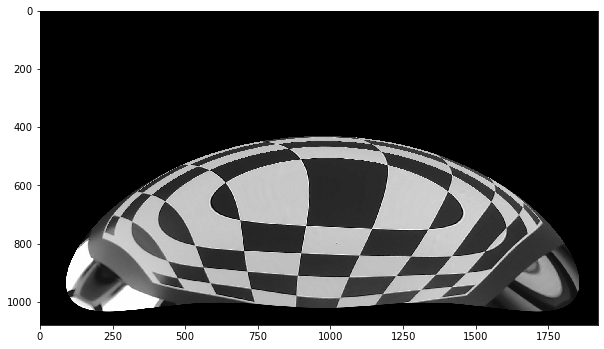

In [47]:
# You should replace these 3 lines with the output in calibration step DIM=XXX
DIM=(1920, 1080)

def undistort(img_path):
    img = cv2.imread(img_path) 
    h,w = img.shape[:2]
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), K, DIM, cv2.CV_16SC2)
    undistorted_img = cv2.remap(img, map1, map2,
    interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    #cv2.imshow("undistorted", undistorted_img) 
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    ID = fname.split(".")[-2].split("/")[-1]
    cv2.imwrite("./hello.png",undistorted_img)
##############################################################################################################################

for fname in images:
    undistort(fname)
#undistort(images[2])
#org = cv2.imread("./hello.jpg")
unfold = cv2.imread("./hello.png")
from matplotlib import pyplot as plt
figure = plt.figure(figsize=(10,10))
#p1= plt.subplot(2,1,1)
#p1.imshow(org)
#p2 = plt.subplot(2,1,2)
plt.imshow(unfold)

plt.show()


# 3. change Balance

- 소실되는 정도를 조절
- 결과 이해불가임, D부터 해결해야될듯함.
<img src="./balance.png" width="600px" height="50px" title="Github_Logo">


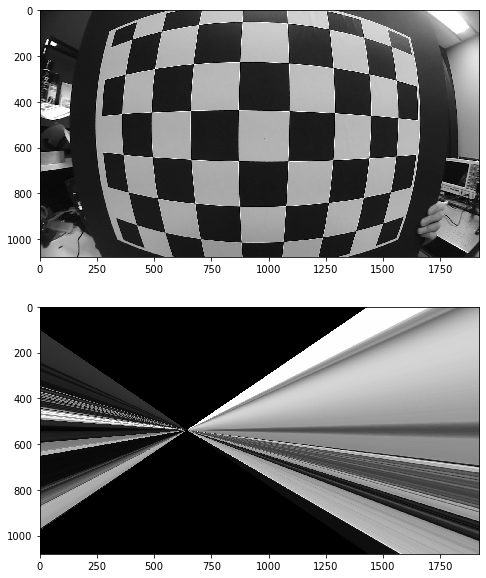

In [4]:
# You should replace these 3 lines with the output in calibration step
def undistort_broader(img_path, balance=0.0, dim2=None, dim3=None):
    img = cv2.imread(img_path)
    dim1 = img.shape[:2][::-1]  #dim1 is the dimension of input image to un-distort
    assert dim1[0]/dim1[1] == DIM[0]/DIM[1], "Image to undistort needs to have same aspect ratio as the ones used in calibration"
    if not dim2:
        dim2 = dim1
    if not dim3:
        dim3 = dim1
    scaled_K = K * dim1[0] / DIM[0]  # The values of K is to scale with image dimension.
    scaled_K[2][2] = 1.0  # Except that K[2][2] is always 1.0
    # This is how scaled_K, dim2 and balance are used to determine the final K used to un-distort image. OpenCV document failed to make this clear!
    new_K = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(scaled_K, D, dim2, np.eye(3), balance=balance)
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(scaled_K, D, np.eye(3), new_K, dim3, cv2.CV_16SC2)
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    ID = fname.split(".")[-2].split("/")[-1]
    cv2.imwrite("./data2/undistorted_broader/unfold_broader_"+ID+".png",undistorted_img)
##############################################################################################################################
    
for fname in images:
    undistort_broader(fname,balance = 1.0)

org = cv2.imread("./data2/00.jpg")
unfold = cv2.imread("./data2/undistorted_broader/unfold_broader_00.png")
from matplotlib import pyplot as plt
figure = plt.figure(figsize=(10,10))
p1= plt.subplot(2,1,1)
p1.imshow(org)
p2 = plt.subplot(2,1,2)
p2.imshow(unfold)

plt.show()